In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

import seaborn as sns
sns.set_context('notebook')
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()
sns.set_color_codes()

import matplotlib.pyplot as plt
plt.xlim(0, 1)
plt.ylim(0, None)
from matplotlib.ticker import MaxNLocator
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 5]

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

import vtk
import numpy as np
import nibabel as nib
from six import iteritems
from scipy.stats import norm
from nibabel.affines import apply_affine
from vtk.util import numpy_support as ns
from dipy.tracking.streamline import values_from_volume

In [2]:
main_folder = '/Users/imag2/Dropbox/IMAG2/MAR/1-4-21_161107'
dirs = os.listdir(main_folder)

In [3]:
def load_nii(fname):
    img = nib.load(fname)
    return img.get_fdata(), img.affine

def read_vtk(filename):
    if filename.endswith('xml') or filename.endswith('vtp'):
        polydata_reader = vtk.vtkXMLPolyDataReader()
    else:
        polydata_reader = vtk.vtkPolyDataReader()

    polydata_reader.SetFileName(filename)
    polydata_reader.Update()

    polydata = polydata_reader.GetOutput()

    return vtkpolydata_to_tracts(polydata)

def vtkpolydata_to_tracts(polydata):
    result = {'lines': ns.vtk_to_numpy(polydata.GetLines().GetData()),
              'points': ns.vtk_to_numpy(polydata.GetPoints().GetData()),
              'numberOfLines': polydata.GetNumberOfLines()
             }

    data = {}
    if polydata.GetPointData().GetScalars():
        data['ActiveScalars'] = polydata.GetPointData().GetScalars().GetName()
    if polydata.GetPointData().GetVectors():
        data['ActiveVectors'] = polydata.GetPointData().GetVectors().GetName()
    if polydata.GetPointData().GetTensors():
        data['ActiveTensors'] = polydata.GetPointData().GetTensors().GetName()

    for i in range(polydata.GetPointData().GetNumberOfArrays()):
        array = polydata.GetPointData().GetArray(i)
        np_array = ns.vtk_to_numpy(array)
        if np_array.ndim == 1:
            np_array = np_array.reshape(len(np_array), 1)
        data[polydata.GetPointData().GetArrayName(i)] = np_array

    result['pointData'] = data

    tracts, data = vtkpolydata_dictionary_to_tracts_and_data(result)
    return tracts, data

def vtkpolydata_dictionary_to_tracts_and_data(dictionary):
    dictionary_keys = {'lines', 'points', 'numberOfLines'}
    if not dictionary_keys.issubset(dictionary):
        raise ValueError("Dictionary must have the keys lines and points" + repr(dictionary))

    tract_data = {}
    tracts = []

    lines = np.asarray(dictionary['lines']).squeeze()
    points = dictionary['points']

    actual_line_index = 0
    number_of_tracts = dictionary['numberOfLines']
    original_lines = []
    for _ in range(number_of_tracts):
        tracts.append(points[lines[actual_line_index + 1:actual_line_index + lines[actual_line_index] + 1]])
        original_lines.append(
            np.array(lines[actual_line_index + 1:actual_line_index + lines[actual_line_index] + 1], copy=True))
        actual_line_index += lines[actual_line_index] + 1

    if 'pointData' in dictionary:
        point_data_keys = [it[0] for it in iteritems(dictionary['pointData']) if isinstance(it[1], np.ndarray)]

        for k in point_data_keys:
            array_data = dictionary['pointData'][k]
            if k not in tract_data:
                tract_data[k] = [array_data[f] for f in original_lines]
            else:
                np.vstack(tract_data[k])
                tract_data[k].extend([array_data[f] for f in original_lines[-number_of_tracts:]])

    return tracts, tract_data

In [4]:
def get_hist(bundle, metric):
    def streamlines_mapvolume(streamlines, volume, affine):
        mapping = values_from_volume(volume, streamlines, affine)
        return mapping

    scalar_measurement = streamlines_mapvolume([bundle[0]], metric, affine)
    scalar_measurement = [item for sublist in scalar_measurement for item in sublist]
    return np.asarray(scalar_measurement)


In [5]:
def plot_fa():
    #f, axes = plt.subplots(ncols=4, nrows=5, figsize=(25,25), gridspec_kw={'width_ratios': [5, 1, 1, 1]})
    #axes[0][0].set_title('FA', weight='bold').set_fontsize('30')
    pd.Series(get_hist(l5, FA)).plot(kind='line', legend=True, label = 'L5')
    pd.Series(get_hist(s1, FA)).plot(kind='line', legend=True, label = 'S1')
    pd.Series(get_hist(s2, FA)).plot(kind='line', legend=True, label = 'S2')
    pd.Series(get_hist(s3, FA)).plot(kind='line', legend=True, label = 'S3')
    #pd.Series(get_hist(s4, FA)).plot.line()
    '''
    try:
        l5_series = pd.Series(get_hist(l5, FA), name="L5")
        sns.lineplot(x='count',y='values',data=l5_series, ax = axes[0][0])
    except:
        pass
    '''
    #plt.show;

    #f.savefig(os.path.abspath(os.path.join(main_folder,current_dir, 'fa.png')));


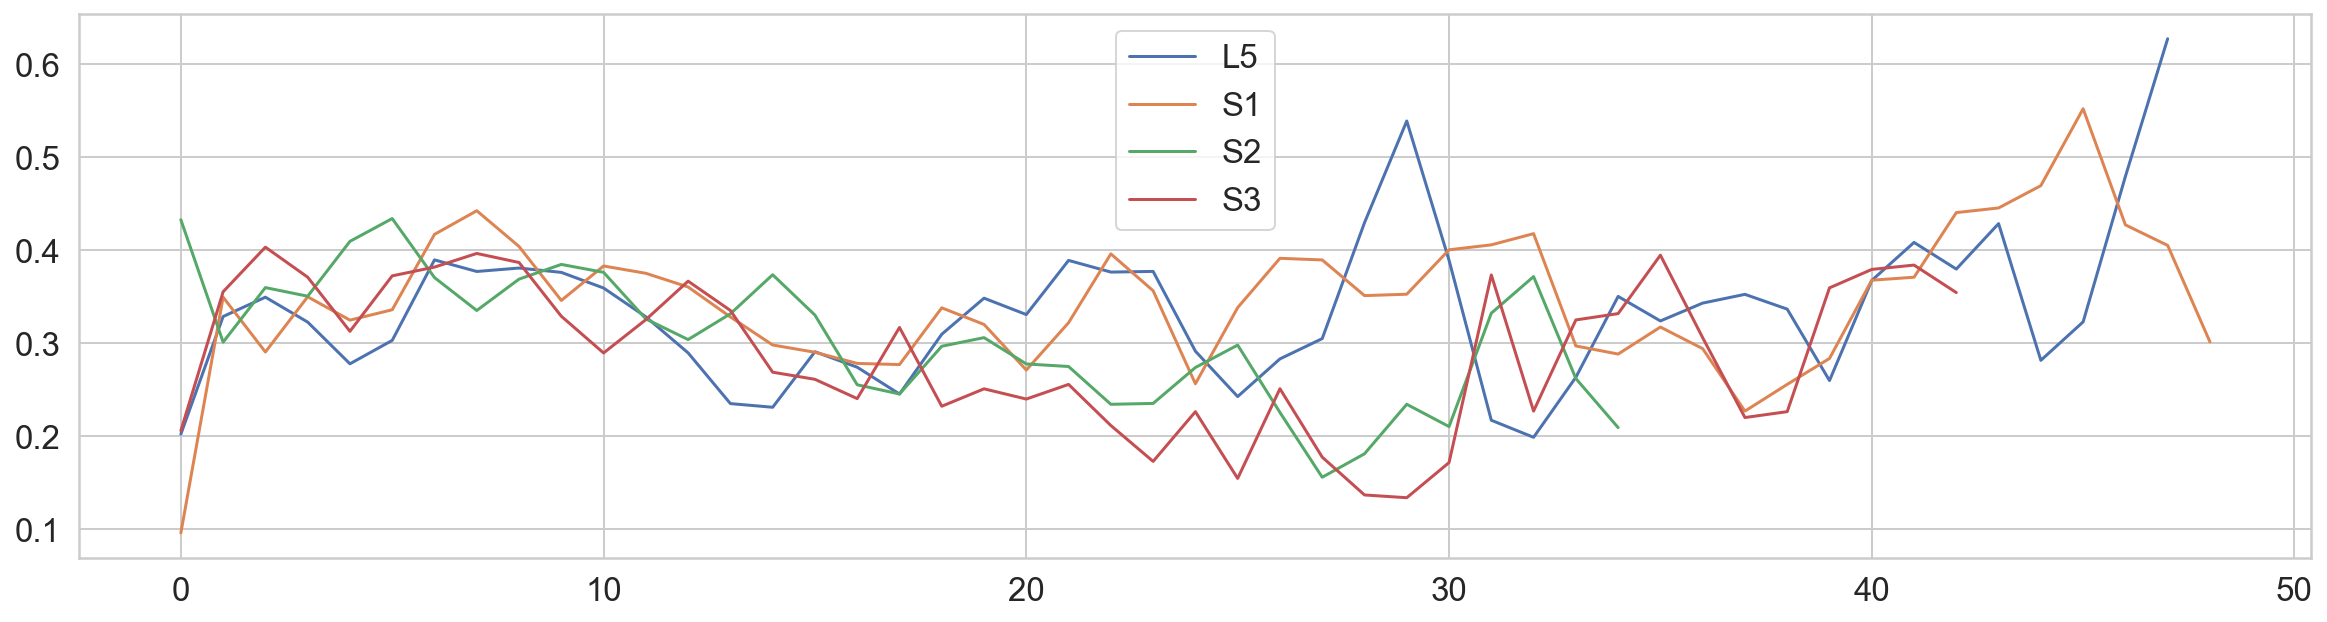

In [6]:
for file in os.listdir(main_folder):
    current_path = os.path.abspath(os.path.join(main_folder, file))
    if '.vtk' in current_path.lower() and 'l5' in current_path.lower():
        l5 = read_vtk(current_path)[0]
    elif '.vtk' in current_path.lower() and 's1' in current_path.lower():
        s1 = read_vtk(current_path)[0]
    elif '.vtk' in current_path.lower() and 's2' in current_path.lower():
        s2 = read_vtk(current_path)[0]
    elif '.vtk' in current_path.lower() and 's3' in current_path.lower():
        s3 = read_vtk(current_path)[0]
    elif '.vtk' in current_path.lower() and 's4' in current_path.lower():
        s4 = read_vtk(current_path)[0]
    elif '.nii' in current_path.lower() and 'fa' in current_path.lower():
        FA, affine = load_nii(current_path)
        FA = (FA - np.amin(FA)) / (np.amax(FA) - np.amin(FA))
    elif '.nii' in current_path.lower() and 'md' in current_path.lower():
        MD, _ = load_nii(current_path)
        MD = (MD - np.amin(MD)) / (np.amax(MD) - np.amin(MD))
    elif '.nii' in current_path.lower() and 'zero' in current_path.lower():
        bzero, _ = load_nii(current_path)
        bzero = (bzero - np.amin(bzero)) / (np.amax(bzero) - np.amin(bzero))
plot_fa()
